In [2]:
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Seq import MutableSeq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import Phylo
import requests
import math



Bad key "text.kerning_factor" on line 4 in
/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Get global ncov tree and convert to Bio Phylo format

In [3]:
tree_url = "https://data.nextstrain.org/ncov_global.json"
# tree_url = "https://data.nextstrain.org/ncov_global_2021-05-20.json"
tree_json = requests.get(tree_url).json()
tree = json_to_tree(tree_json)

Add information about synonymous mutations as an attribute of the tree

In [4]:
# make dictionary with gene name as key and reference sequence of that gene as value
reference_sequence_aa = {}
reference_sequence_nt = {}


# make dictionary giving gene by genomic location 
reference_gene_locations = {}

# make dictionary saying what codon within the gene a certain genomic location falls within
# and whether the mutation is at pos 0, 1 or 2 within codon
reference_gene_codon = {}

for record in SeqIO.parse(open("reference_seq_edited.gb","r"), "genbank"):
    genome_seq = record.seq
    for feature in record.features:
        if feature.type == 'CDS':
            # allow RdRp to overwrite Orf1a and Orf1b, 
            # to take care of changed reading frame due to  ribosome slippage
            # S1 and S2 will also overwrite spike
            for pos in range(int(feature.location.start), int(feature.location.end)):
                reference_gene_locations[pos] = feature.qualifiers['gene'][0]
                codon_num = math.floor((pos-feature.location.start)/3)
                pos_in_codon = ((pos-feature.location.start)-codon_num*3)
                reference_gene_codon[pos] = (codon_num, pos_in_codon)
                
            gene_seq = feature.location.extract(record.seq)
            reference_sequence_nt[feature.qualifiers['gene'][0]] = gene_seq
            gene_seq_aa = gene_seq.translate()
            reference_sequence_aa[feature.qualifiers['gene'][0]] = gene_seq_aa

/Users/katekistler/anaconda3/envs/nextstrain/lib/python3.6/site-packages/Bio/Seq.py:2859: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [45]:
# dictionary of list of colors for emerging lineages, depending on total number of lineages
color_palettes = {8: ['#4068CF','#5098B9','#6CB28C','#94BD62','#BFBB47','#DFA53B','#E67131','#DB2823'], 
                  9: ['#3E5DD0','#4A8CC2','#60AA9E','#80B974','#A6BE55','#CBB742','#E29D39','#E56A2F','#DB2823'], 
                  10: ['#3F52CD','#4681CA','#57A1AD','#70B487','#90BC65','#B4BD4C','#D3B240','#E59638','#E4642E','#DB2823'], 
                  11: ['#3F47C9','#4274CE','#4F97BB','#64AC99','#7EB976','#9EBE5A','#BEBB48','#D9AE3E','#E69036','#E35F2D','#DB2823'], 
                  12: ['#403CC5','#4067CF','#4A8BC3','#5AA4A9','#6FB488','#8BBB69','#A9BD53','#C7B944','#DDA93C','#E68A35','#E35C2C','#DB2823'], 
                  13: ['#4433BE','#3E5ACF','#457FCB','#529AB6','#64AD98','#7BB77A','#96BD60','#B3BD4D','#CDB642','#DFA43B','#E68434','#E2582C','#DB2823'], 
                  14: ['#492AB5','#3F4CCB','#4271CE,''#4C8FC0','#5AA5A8','#6DB38A','#85BA6F','#A0BE59','#BBBC49','#D2B340','#E19F3A','#E68033','#E2562B','#DB2823'], 
                  15: ['#4D21AD','#403FC6','#3F63CF','#4783C8','#539BB5','#63AC9B','#77B67F','#8EBC66','#A8BD53','#C1BA47','#D6B03F','#E39C39','#E67C33','#E1532B','#DB2823'], 
                  16: ['#571EA2','#4334BF','#3F55CE','#4376CD','#4C91C0','#59A4A9','#6AB18F','#7FB975','#97BD5F','#AFBD4F','#C7B944','#D9AD3D','#E49838','#E67932','#E1512A','#DB2823']}
                      

In [5]:
#Function to find path from root to clade
def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path

In [6]:
def nuc_changes_from_reference(muts_on_path):
    """
    From all the of the nucleotide changes that have occurred on the path from root to branch, 
    find the most recent nuc mutation at each site (giving the genotype at the branch)
    """
    
    final_muts_from_ref = {}

    # overwrites genotypes at pos in historical order
    for x in muts_on_path:
        x_pos = int(x[1:-1])
        final_muts_from_ref[x_pos] = x[-1]
        

    return final_muts_from_ref

In [7]:
def determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref):
    
    parent_diffs_pos = [int(k) for k,v in parent_diffs_from_ref.items()]

    
    # make dictionary of synonymous (and noncoding) mutations to add to tree
    syn_muts = {}
    
    # don't care about deletions because they are obviously not synonymous
    for mut in nuc_muts_on_branch:
        if mut[-1]!= '-' and mut[0]!='-':
            mut_pos = int(mut[1:-1])
            # find what gene this mut happens in
            if (mut_pos-1) in reference_gene_locations.keys():
                mut_gene = reference_gene_locations[mut_pos-1]
                mut_codon_num = reference_gene_codon[mut_pos-1][0]
                mut_codon_pos = reference_gene_codon[mut_pos-1][1]
                
                # find the reference sequence of the codon this mutation occurs in
                codon_ref_aa = reference_sequence_aa[mut_gene][mut_codon_num]
                
                codon_ref_nt = reference_sequence_nt[mut_gene][(mut_codon_num*3):(mut_codon_num*3+3)]
                
                # check if a mutation occurred within the same codon in a parent
                # and if so, change the reference codon sequence accordingly, 
                # to tell whether the mutation at this branch is synonymous or not
                codon_genome_pos = list(range((mut_pos-1-mut_codon_pos),(mut_pos-1-mut_codon_pos+3)))
                
                parent_codon = codon_ref_nt
                for parent_diff in parent_diffs_pos:
                    parent_diff_zero_based = parent_diff-1
                    if parent_diff_zero_based in codon_genome_pos:
                        parent_diff_pos = codon_genome_pos.index(parent_diff_zero_based)
                        parent_codon = MutableSeq(str(codon_ref_nt))
                        parent_codon[parent_diff_pos] = parent_diffs_from_ref[parent_diff]
                        parent_codon = parent_codon.toseq()
                
                
                codon_mutated = MutableSeq(str(parent_codon))
                codon_mutated[mut_codon_pos] = mut[-1]
                codon_mutated = codon_mutated.toseq()
                codon_mutated_translation = codon_mutated.translate()
                
                if str(codon_ref_aa) == str(codon_mutated_translation):
                    if mut_gene in syn_muts.keys():
                        syn_muts[mut_gene] += [mut]
                    else:
                        syn_muts[mut_gene] = [mut]
                        
                

            else:
                if 'noncoding' in syn_muts.keys():
                    syn_muts['noncoding'] += [mut]
                else:
                    syn_muts['noncoding'] = [mut]
                    
    return syn_muts

In [10]:
def add_syn_mut_attribute(tree):
    
    for node in tree.find_clades():

        node.node_attrs['syn_muts'] = {}

        # only care if this branch has some nucleotide mutations
        if hasattr(node, 'branch_attrs'):
            if 'nuc' in node.branch_attrs['mutations']:

                nuc_muts_on_branch = node.branch_attrs['mutations']['nuc']

                node_path = get_parent(tree, node)

                nucleotide_mut_path = []

                # find all nucleotide mutations that happened in parents, 
                # in case they affect codons mutated on this branch
                for parent in node_path[-1]:
                    if hasattr(parent, 'branch_attrs'):
                        if 'nuc' in parent.branch_attrs['mutations']:
                            nucleotide_mut_path+=parent.branch_attrs['mutations']['nuc']

                parent_diffs_from_ref = nuc_changes_from_reference(nucleotide_mut_path)

                syn_muts_dict = determine_synonymous(nuc_muts_on_branch, parent_diffs_from_ref)

                node.node_attrs['syn_muts'] = syn_muts_dict


In [11]:
add_syn_mut_attribute(tree)

S1 mutations (from root-to-clade) are already a feature of each node in the tree. Count RdRp mutations via tree traversal and add this count to each node

In [12]:
#Find the path from root to internal node and accumulate all mutations that have occurred along this path
#Keep track of these just for S1, S2, and RdRp 

def get_parent(tree, child_clade):
    node_path = tree.get_path(child_clade)
    return node_path


def consolidate_deletions(mutation_list):
    """
    For deletion mutations, consider adjacent sites as part of the same deletion
    """
    mutation_count = len([x for x in mutation_list if x[-1]!='-'])
    deletions_only = sorted([int(x[1:-1]) for x in mutation_list if x[-1]=='-'])

    # if there are deletions, count a run of consecutive sites as a single deletion/mutation
    if len(deletions_only) != 0:
        mutation_count+=1

        deletion_tracker = deletions_only[0]
        for deleted_pos in deletions_only[1:]:
            if deleted_pos == deletion_tracker+1:
                pass
            else:
                mutation_count+=1
            deletion_tracker = deleted_pos
    return mutation_count

def remove_reversions(mutation_list):
    """
    If site mutates and then reverts, do not count this in the mutation tally.
    If site mutates and then mutates again (but not a reversion), count only the second mutation
    """
    mutation_list_pos = [int(x[1:-1]) for x in mutation_list]
    sites_mutated_twice = set([x for x in mutation_list_pos if mutation_list_pos.count(x) > 1])
    # find if twice-mutated site was a reversion
    for site in sites_mutated_twice:
        muts_at_site = [mut for mut in mutation_list if int(mut[1:-1])==site]

        # if site reverts, remove all mutations at this site
        if muts_at_site[0][0] == muts_at_site[-1][-1]:
            for mut in range(len(muts_at_site)):
                mutation_list.remove(muts_at_site[mut])
        # if the site mutates multiple times, but doesn't revert, keep last mutation
        else:
            for mut in range(len(muts_at_site)-1):
                mutation_list.remove(muts_at_site[mut])
    return mutation_list
    
    


for node in tree.find_clades():
    
#     if "S1_mutations" in node.node_attrs:
#         s1_mutations = node.node_attrs["S1_mutations"]["value"]
    
    #Find all parents of the node
    parents = get_parent(tree, node)

    #Find mutations that occur in the parents
    parents_spike_muts = []
    parents_s1_muts = []
    parents_s2_muts = []
    parents_rdrp_muts = []
    parents_nsp6_muts = []
    parents_nsp4_muts = []
    parents_n_muts = []
    parents_e_muts = []
    parents_m_muts = []
    
    parents_s1_syn = []

    for parent in parents:
        if hasattr(parent, "branch_attrs") and "mutations" in parent.branch_attrs:
            if "S" in parent.branch_attrs["mutations"]:
                parents_spike_muts+=parent.branch_attrs["mutations"]["S"]
                for mut in parent.branch_attrs["mutations"]["S"]: 
                    # nextstrain calls pos 13 in sigpep, not S1
                    if int(mut[1:-1]) in range(14,686):
                        parents_s1_muts+=[mut]
                    elif int(mut[1:-1]) in range(687,1274):
                        parents_s2_muts+=[mut]
            #find RdRp muts
            #and Nsp4 and 6 muts
            elif "ORF1a" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1a"]:
                    if int(mut[1:-1]) in range(4492,4401):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])-4492}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
                    elif int(mut[1:-1]) in range(3570,3859):
                        #renumber mut according to nsp6 protein
                        nsp6_mut = f'{mut[0]}{int(mut[1:-1])-3570}{mut[-1]}'
                        parents_nsp6_muts+=[nsp6_mut]
                    elif int(mut[1:-1]) in range(2777,3261):
                        #renumber mut according to nsp6 protein
                        nsp4_mut = f'{mut[0]}{int(mut[1:-1])-2777}{mut[-1]}'
                        parents_nsp4_muts+=[nsp4_mut]
            elif "ORF1b" in parent.branch_attrs["mutations"]:
                for mut in parent.branch_attrs["mutations"]["ORF1b"]:
                    if int(mut[1:-1]) in range(1,923):
                        #renumber mut according to rdrp protein
                        rdrp_mut = f'{mut[0]}{int(mut[1:-1])+9}{mut[-1]}'
                        parents_rdrp_muts+=[rdrp_mut]
            # find N muts
            elif "N" in parent.branch_attrs["mutations"]:
                parents_n_muts+=parent.branch_attrs["mutations"]["N"]
            # find E muts
            elif "E" in parent.branch_attrs["mutations"]:
                parents_e_muts+=parent.branch_attrs["mutations"]["E"]
            # find M muts
            elif "M" in parent.branch_attrs["mutations"]:
                parents_m_muts+=parent.branch_attrs["mutations"]["M"]
        if hasattr(parent, 'node_attrs') and 'syn_muts' in parent.node_attrs:
            if 'S1' in parent.node_attrs['syn_muts']:
                parents_s1_syn += parent.node_attrs['syn_muts']['S1']
            

    # remove reversion mutations from each list
    parents_spike_muts = remove_reversions(parents_spike_muts)
    parents_s1_muts = remove_reversions(parents_s1_muts)
    parents_s2_muts = remove_reversions(parents_s2_muts)
    parents_rdrp_muts = remove_reversions(parents_rdrp_muts)
    parents_nsp6_muts = remove_reversions(parents_nsp6_muts)
    parents_nsp4_muts = remove_reversions(parents_nsp4_muts)
    parents_n_muts = remove_reversions(parents_n_muts)
    parents_e_muts = remove_reversions(parents_e_muts)
    parents_m_muts = remove_reversions(parents_m_muts)



    # count deletion of adjacent nucleotides as one mutation event
    spike_mutation_count = consolidate_deletions(parents_spike_muts)
    s1_mutation_count = consolidate_deletions(parents_s1_muts)
    s2_mutation_count = consolidate_deletions(parents_s2_muts)
    rdrp_mutation_count = consolidate_deletions(parents_rdrp_muts)
    nsp6_mutation_count = consolidate_deletions(parents_nsp6_muts)
    nsp4_mutation_count = consolidate_deletions(parents_nsp4_muts)
    n_mutation_count = consolidate_deletions(parents_n_muts)
    e_mutation_count = consolidate_deletions(parents_e_muts)
    m_mutation_count = consolidate_deletions(parents_m_muts)

    # where s1_mutations != s1_mutation_count seems to be when substitution is adjacent to deletion 
#     if hasattr(node, 'node_attrs') and 'S1_mutations' in node.node_attrs:
#         deletions_only = sorted([x for x in parents_s1_muts if x[-1]=='-'])
#         if len(deletions_only)>0:
#         if s1_mutation_count != node.node_attrs["S1_mutations"]["value"]:
#             print(node.name)
#             print(s1_mutation_count, node.node_attrs["S1_mutations"]["value"])
#             print(parents_s1_muts)

    node.node_attrs["s1_syn"] = len(parents_s1_syn)
    
    node.node_attrs["spike_muts"] = spike_mutation_count
    node.node_attrs["s1_muts"] = s1_mutation_count
    node.node_attrs["s2_muts"] = s2_mutation_count
    node.node_attrs["rdrp_muts"] = rdrp_mutation_count
    node.node_attrs["nsp6_muts"] = nsp6_mutation_count
    node.node_attrs["nsp4_muts"] = nsp4_mutation_count
    node.node_attrs["n_muts"] = n_mutation_count
    node.node_attrs["e_muts"] = e_mutation_count
    node.node_attrs["m_muts"] = m_mutation_count

Make dataframe to plot 1) accumulation of S1 vs RdRp mutations over time, 2) S1 vs RdRp mutation count versus logistic growth

In [13]:
# make dataframe of relevant information
muts_information = []

for node in tree.find_clades(terminal=False):

    
    logistic_growth = None
    if "logistic_growth" in node.node_attrs:
        logistic_growth = node.node_attrs["logistic_growth"]["value"]
    
    if hasattr(node, "node_attrs"):
        date = node.node_attrs["num_date"]["value"]
        clade_membership = 'other'
        if 'clade_membership' in node.node_attrs:
            clade_membership = node.node_attrs['clade_membership']['value']
            

        if 'emerging_lineage' in node.node_attrs:
            emerging_lineage = node.node_attrs['emerging_lineage']['value']



        #make tidy df for seaborn plotting
        muts_information.append({'clade': node.name, 'date': date,
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "S1", 
                                 'num_muts': node.node_attrs["s1_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date,
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "S1_synonymous", 
                                 'num_muts': node.node_attrs["s1_syn"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date, 
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "RdRp", 
                                 'num_muts': node.node_attrs["rdrp_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date, 
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "N", 
                                 'num_muts': node.node_attrs["n_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date, 
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "E", 
                                 'num_muts': node.node_attrs["e_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date, 
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "M", 
                                 'num_muts': node.node_attrs["m_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date, 
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "Nsp6", 
                                 'num_muts': node.node_attrs["nsp6_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date, 
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "Nsp4", 
                                 'num_muts': node.node_attrs["nsp4_muts"],  
                                 'logistic_growth': logistic_growth})
        muts_information.append({'clade': node.name, 'date': date,
                                 'clade_membership': clade_membership,
                                 'emerging_lineage': emerging_lineage,
                                 'mut_location': "S2", 
                                 'num_muts': node.node_attrs["s2_muts"],  
                                 'logistic_growth': logistic_growth})

muts_information_df = pd.DataFrame(muts_information)
    


In [14]:
# want regplot with a hue option (lmplot doesn't have ax)
def hue_regplot(data, x, y, hue, palette=None, **kwargs):
    from matplotlib.cm import get_cmap
    
    regplots = []
    
    levels = data[hue].unique()
    
    if palette is None:
        default_colors = get_cmap('tab10')
        palette = {k: default_colors(i) for i, k in enumerate(levels)}
    
    for key in levels:
        regplots.append(
            sns.regplot(
                x=x,
                y=y,
                data=data[data[hue] == key],
                color=palette[key],
                **kwargs
            )
        )
    
    return regplots

In [15]:
# plot number of s1 and rdrp mutations over time
# color by clade membership
def plot_muts_vs_time(clade_coloring, filename=None):
    if clade_coloring=="clade_membership":
        cmap = {"19A":"#5034D2", "19B": "#4665EC", "20A": "#4F91E5", 
                       "20B": "#60B2CA", "20C": "#77C7A4", "20D":"#94D37F", 
                       "20E (EU1)": "#B8D863", "20F":"#DBD351", "20G":"#F6C446", 
                       "20H/501Y.V2":"#FFA53D", "20I/501Y.V1":"#FF7135", "20J/501Y.V3":"#F93529"}

    if clade_coloring=="emerging_lineage":
        cmap = {"A.23.1": "#5725c4", "B.1.1.7 (Alpha)": "#4947e0", "B.1.1.519": "#4770eb",
                "B.1.351 (Beta)": "#5094e3", "B.1.427/429 (Epsilon)":"#5eb0cd", 
                "B.1.525 (Eta)":"#70c3b0", "B.1.526 (Iota)":"#87ce90", 
                "B.1.617.1 (Kappa)":"#a1d574", "B.1.617.2 (Delta)":"#bed65e", "B.1.619":"#dbd350", 
                "B.1.620":"#f2c747", "B.1.621":"#ffb141",
                "C.37":"#ff8c3a", "P.1 (Gamma)":"#ff5e31", 'unassigned':"#ABABAB"}

    sns.set_style("white")
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
    plt.tight_layout()


    # plot S1 mutations versus date, color by clade membership
    ax1 = sns.scatterplot(x="date", y="num_muts", hue=clade_coloring,
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                          ax=ax1, legend=False)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax1, 
                data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                line_kws={"color":'black'}, ci=95)
    ax1.set_ylabel('Number of mutations', fontsize = 12)
    ax1.set_xlabel('Date', fontsize = 12)
    ax1.set_title('S1', fontsize = 14)

    # plot rdrp mutations versus date, color by clade membership
    ax2 = sns.scatterplot(x="date", y="num_muts", hue=clade_coloring,
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='RdRp'], ax=ax2)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax2, 
                data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                line_kws={"color":'black'}, ci=95)
    ax2.set_xlabel('Date', fontsize = 12)
    ax2.set_title('RdRp', fontsize = 14)
    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.25, 1.0))

    if filename:
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

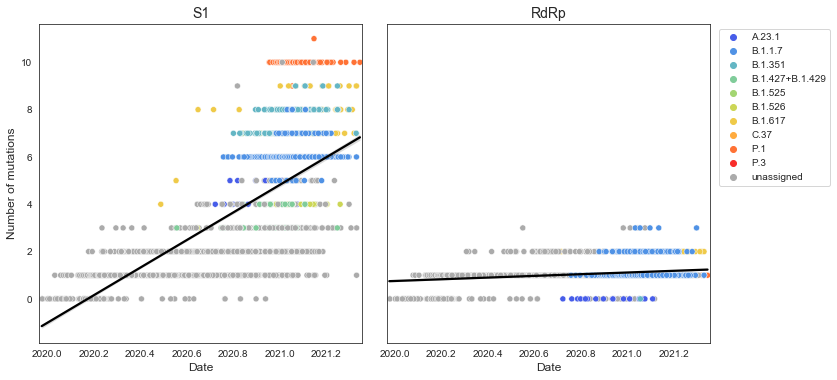

In [12]:
plot_muts_vs_time("emerging_lineage", filename='plots/fig1a_color_by_emerging_clade.png')

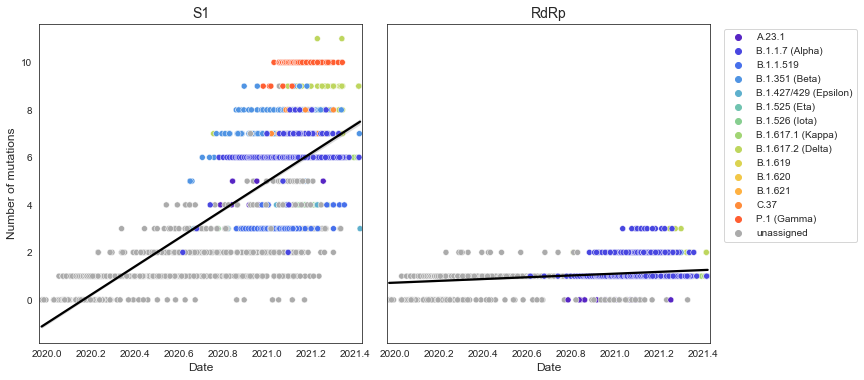

In [78]:
plot_muts_vs_time("emerging_lineage", filename='plots/fig1a_color_by_emerging_clade.png')

In [16]:
# plot number of s1 and rdrp mutations versus logistic growth rate
# color by clade membership


def plot_muts_vs_logistic_growth(clade_coloring, filename=None):
    if clade_coloring=="clade_membership":
        cmap = {"19A":"#5034D2", "19B": "#4665EC", "20A": "#4F91E5", 
                       "20B": "#60B2CA", "20C": "#77C7A4", "20D":"#94D37F", 
                       "20E (EU1)": "#B8D863", "20F":"#DBD351", "20G":"#F6C446", 
                       "20H/501Y.V2":"#FFA53D", "20I/501Y.V1":"#FF7135", "20J/501Y.V3":"#F93529"}

    if clade_coloring=="emerging_lineage":
        cmap = {"A.23.1": "#5725c4", "B.1.1.7 (Alpha)": "#4947e0", "B.1.1.519": "#4770eb",
                "B.1.351 (Beta)": "#5094e3", "B.1.427/429 (Epsilon)":"#5eb0cd", 
                "B.1.525 (Eta)":"#70c3b0", "B.1.526 (Iota)":"#87ce90", 
                "B.1.617.1 (Kappa)":"#a1d574", "B.1.617.2 (Delta)":"#bed65e", "B.1.619":"#dbd350", 
                "B.1.620":"#f2c747", "B.1.621":"#ffb141",
                "C.37":"#ff8c3a", "P.1 (Gamma)":"#ff5e31", 'unassigned':"#ABABAB"}


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=True)
    plt.tight_layout()

    # plot S1 mutations versus logistic growth, color by clade membership
    ax1 = sns.scatterplot(x="logistic_growth", y="num_muts", hue=clade_coloring,
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                          ax=ax1, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax1, 
                data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                line_kws={"color":'black'}, ci=95)
    ax1.set_ylabel('Number of mutations', fontsize = 12)
    ax1.set_xlabel('Logistic Growth Rate', fontsize = 12)
    ax1.set_title('S1', fontsize = 14)

    # plot rdrp mutations versus logistic growth, color by clade membership
    ax2 = sns.scatterplot(x="logistic_growth", y="num_muts", hue=clade_coloring,
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='RdRp'], ax=ax2)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax2, 
                data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                line_kws={"color":'black'}, ci=95)
    ax2.set_xlabel('Logistic Growth Rate', fontsize = 12)
    ax2.set_title('RdRp', fontsize = 14)
    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.25, 1.0))


    if filename: 
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

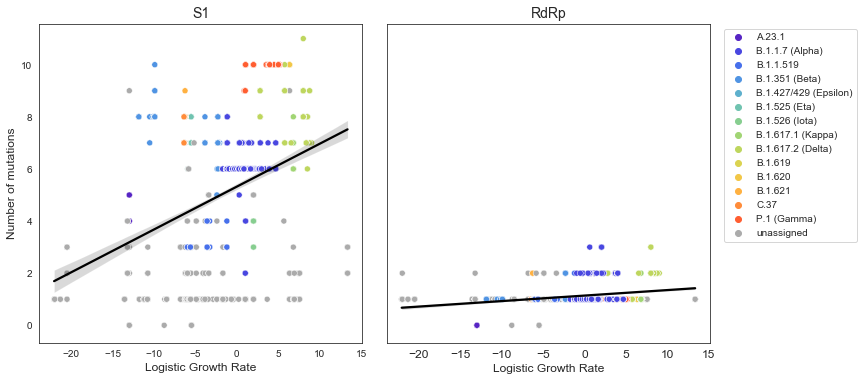

In [130]:
plot_muts_vs_logistic_growth("emerging_lineage", filename='plots/fig1b_color_by_emerging_clade.png')

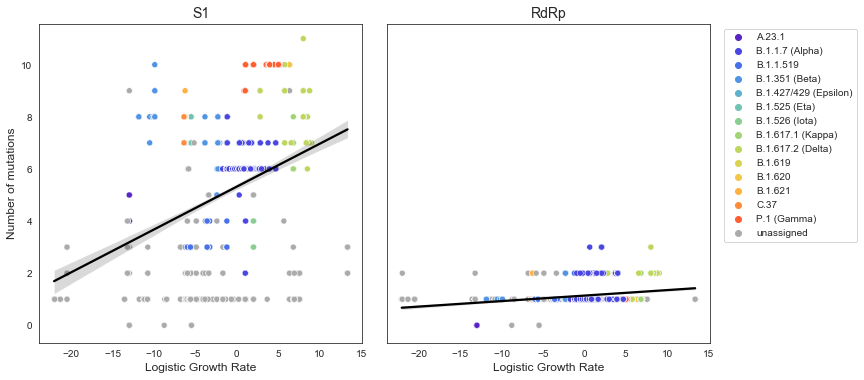

In [80]:
plot_muts_vs_logistic_growth("emerging_lineage", filename='plots/fig1b_color_by_emerging_clade.png')

In [43]:
# plot number of s1 and rdrp mutations versus logistic growth rate
# color by clade membership


def plot_muts_vs_logistic_growth_s1_syn_vs_nonsyn(filename=None):
    
    all_emerging_lineages = sorted(list(set(muts_information_df['emerging_lineage'])))
    all_emerging_lineages.remove('unassigned')
    colors_to_use = color_palettes[len(all_emerging_lineages)]
    
    cmap = dict(zip(all_emerging_lineages, colors_to_use))
    cmap['unassigned'] = "#ABABAB"

    


    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2,3, figsize=(14,10), sharey=True)
    plt.tight_layout()



    # plot S1 mutations versus date, color by clade membership
    ax1 = sns.scatterplot(x="date", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                          ax=ax1, legend=False)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax1, 
                data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                line_kws={"color":'black'}, ci=95)
    ax1.set_ylabel('Number of mutations', fontsize = 14)
    ax1.set_xlabel('Date', fontsize = 14)
    ax1.set_title('S1 nonsynonymous', fontsize = 16, fontweight='bold')

    # plot s1 syn mutations versus date, color by clade membership
    ax2 = sns.scatterplot(x="date", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1_synonymous'], 
                          ax=ax2, legend=False)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax2, 
                data = muts_information_df[muts_information_df['mut_location']=='S1_synonymous'], 
                line_kws={"color":'black'}, ci=95)
    ax2.set_xlabel('Date', fontsize = 14)
    ax2.set_title('S1 synonymous', fontsize = 16, fontweight='bold')


    # plot rdrp mutations versus date, color by clade membership
    ax3 = sns.scatterplot(x="date", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                          ax=ax3, legend=False)
    # add linear regression line
    sns.regplot(x="date", y="num_muts", scatter=False, ax=ax3, 
                data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                line_kws={"color":'black'}, ci=95)
    ax3.set_xlabel('Date', fontsize = 14)
    ax3.set_title('RdRp', fontsize = 16, fontweight='bold')


    # plot S1 mutations versus logistic growth, color by clade membership
    ax4 = sns.scatterplot(x="logistic_growth", y="num_muts", hue = 'emerging_lineage', 
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                          ax=ax4, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax4, 
                data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                line_kws={"color":'black'}, ci=95)
    ax4.set_ylabel('Number of mutations', fontsize = 14)
    ax4.set_xlabel('Logistic Growth Rate', fontsize = 14)
    ax4.set_title('S1 nonsynonymous', fontsize = 16, fontweight='bold')

    # plot s1 syn mutations versus logistic growth, color by clade membership
    ax5 = sns.scatterplot(x="logistic_growth", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1_synonymous'], 
                          ax=ax5, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax5, 
                data = muts_information_df[muts_information_df['mut_location']=='S1_synonymous'], 
                line_kws={"color":'black'}, ci=95)
    ax5.set_xlabel('Logistic Growth Rate', fontsize = 14)
    ax5.set_title('S1 synonymous', fontsize = 16, fontweight='bold')


    
    # plot rdrp mutations versus logistic growth, color by clade membership
    ax6 = sns.scatterplot(x="logistic_growth", y="num_muts", hue= 'emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                          ax=ax6)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax6, 
                data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                line_kws={"color":'black'}, ci=95)
    ax6.set_xlabel('Logistic Growth Rate', fontsize = 14)
    ax6.set_title('RdRp', fontsize = 16, fontweight='bold')
    handles, labels = ax6.get_legend_handles_labels()
    lgd = ax6.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.9, 1.2))

    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.3)
    
    for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
        plt.setp(ax.get_xticklabels(), fontsize=12)
        plt.setp(ax.get_yticklabels(), fontsize=12)
    
    plt.figtext(0.0, 0.98, 'A', fontsize=24, fontweight='bold')
    plt.figtext(0.0, 0.48, 'B', fontsize=24, fontweight='bold')
    

    if filename: 
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

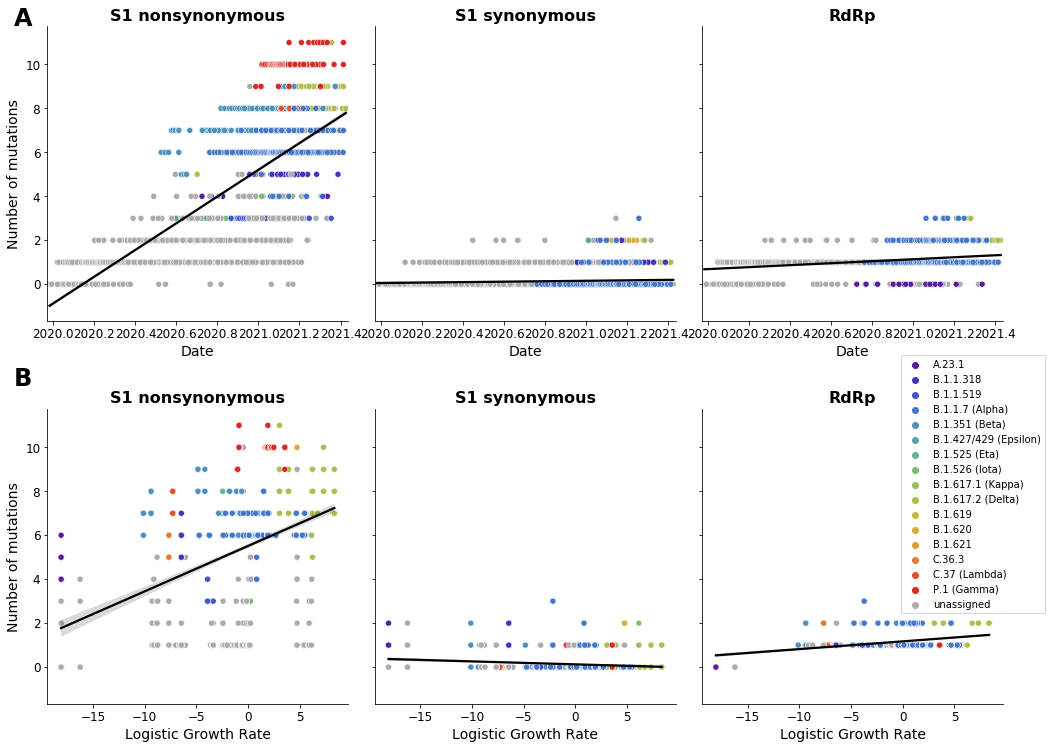

In [44]:
plot_muts_vs_logistic_growth_s1_syn_vs_nonsyn()

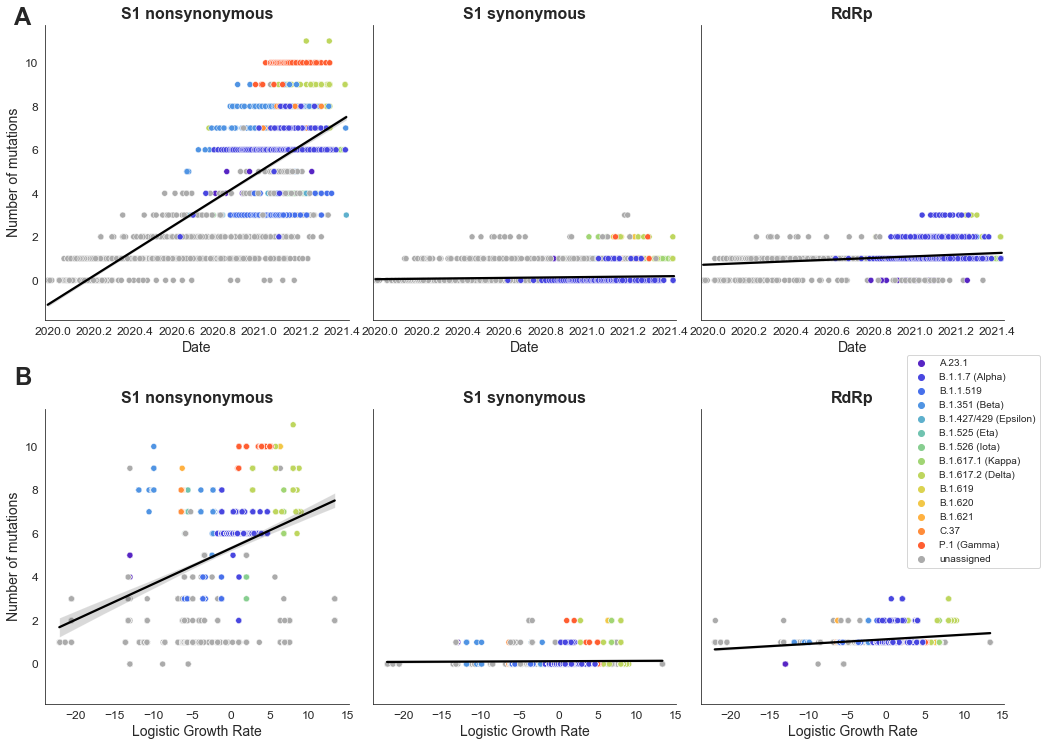

In [171]:
plot_muts_vs_logistic_growth_s1_syn_vs_nonsyn(filename = 'plots/fig1_a_and_b.png')

In [178]:
def plot_muts_vs_logistic_growth_all_genes(filename=None):

    cmap = {"A.23.1": "#5725c4", "B.1.1.7 (Alpha)": "#4947e0", "B.1.1.519": "#4770eb",
            "B.1.351 (Beta)": "#5094e3", "B.1.427/429 (Epsilon)":"#5eb0cd", 
            "B.1.525 (Eta)":"#70c3b0", "B.1.526 (Iota)":"#87ce90", 
            "B.1.617.1 (Kappa)":"#a1d574", "B.1.617.2 (Delta)":"#bed65e", "B.1.619":"#dbd350", 
            "B.1.620":"#f2c747", "B.1.621":"#ffb141",
            "C.37":"#ff8c3a", "P.1 (Gamma)":"#ff5e31", 'unassigned':"#ABABAB"}


    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(10,10), 
                                                                         sharey=True, sharex=True)
    plt.tight_layout()

    # plot S1 mutations versus logistic growth, color by clade membership
    ax1 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                          ax=ax1, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax1, 
                data = muts_information_df[muts_information_df['mut_location']=='S1'], 
                line_kws={"color":'black'}, ci=95)
    ax1.set_ylabel('Number of mutations', fontsize = 12)
    ax1.set_xlabel('', fontsize = 12)
    ax1.set_title('S1', fontsize = 14, fontweight= 'bold')
    
    # plot S2 mutations versus logistic growth, color by clade membership
    ax2 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='S2'], 
                          ax=ax2)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax2, 
                data = muts_information_df[muts_information_df['mut_location']=='S2'], 
                line_kws={"color":'black'}, ci=95)
    ax2.set_xlabel('', fontsize = 12)
    ax2.set_title('S2', fontsize = 14, fontweight= 'bold')
    
    # plot Rdrp mutations versus logistic growth, color by clade membership
    ax3 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                          ax=ax3, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax3, 
                data = muts_information_df[muts_information_df['mut_location']=='RdRp'], 
                line_kws={"color":'black'}, ci=95)
    ax3.set_ylabel('Number of mutations', fontsize = 12)
    ax3.set_xlabel('', fontsize = 12)
    ax3.set_title('RdRp', fontsize = 14, fontweight= 'bold')

    # plot N mutations versus logistic growth, color by clade membership
    ax4 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='N'], 
                          ax=ax4, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax4, 
                data = muts_information_df[muts_information_df['mut_location']=='N'], 
                line_kws={"color":'black'}, ci=95)
    ax4.set_xlabel('', fontsize = 12)
    ax4.set_title('N', fontsize = 14, fontweight= 'bold')
    
    # plot E mutations versus logistic growth, color by clade membership
    ax5 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='E'], 
                          ax=ax5, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax5, 
                data = muts_information_df[muts_information_df['mut_location']=='E'], 
                line_kws={"color":'black'}, ci=95)
    ax5.set_ylabel('Number of mutations', fontsize = 12)
    ax5.set_xlabel('', fontsize = 12)
    ax5.set_title('E', fontsize = 14, fontweight= 'bold')
    
    # plot M mutations versus logistic growth, color by clade membership
    ax6 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='M'], 
                          ax=ax6, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax6, 
                data = muts_information_df[muts_information_df['mut_location']=='M'], 
                line_kws={"color":'black'}, ci=95)
    ax6.set_xlabel('', fontsize = 12)
    ax6.set_title('M', fontsize = 14, fontweight= 'bold')
    
    # plot Nsp6 mutations versus logistic growth, color by clade membership
    ax7 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='Nsp6'], 
                          ax=ax7, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax7, 
                data = muts_information_df[muts_information_df['mut_location']=='Nsp6'], 
                line_kws={"color":'black'}, ci=95)
    ax7.set_ylabel('Number of mutations', fontsize = 12)
    ax7.set_xlabel('Logistic Growth Rate', fontsize = 12)
    ax7.set_title('Nsp6', fontsize = 14, fontweight= 'bold')
    
    # plot Nsp6 mutations versus logistic growth, color by clade membership
    ax8 = sns.scatterplot(x="logistic_growth", y="num_muts", hue='emerging_lineage',
                          hue_order= list(cmap.keys()), palette=cmap,
                          data = muts_information_df[muts_information_df['mut_location']=='Nsp4'], 
                          ax=ax8, legend=False)
    # add linear regression line
    sns.regplot(x="logistic_growth", y="num_muts", scatter=False, ax=ax8, 
                data = muts_information_df[muts_information_df['mut_location']=='Nsp4'], 
                line_kws={"color":'black'}, ci=95)
    ax8.set_xlabel('Logistic Growth Rate', fontsize = 12)
    ax8.set_title('Nsp4', fontsize = 14, fontweight= 'bold')
    
    handles, labels = ax2.get_legend_handles_labels()
    lgd = ax2.legend(handles, labels, loc='upper center', bbox_to_anchor=(1.2, 1.0))
    
    sns.despine(left=False, bottom=False)
    plt.subplots_adjust(hspace=0.25)

    if filename: 
        fig.savefig(filename, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

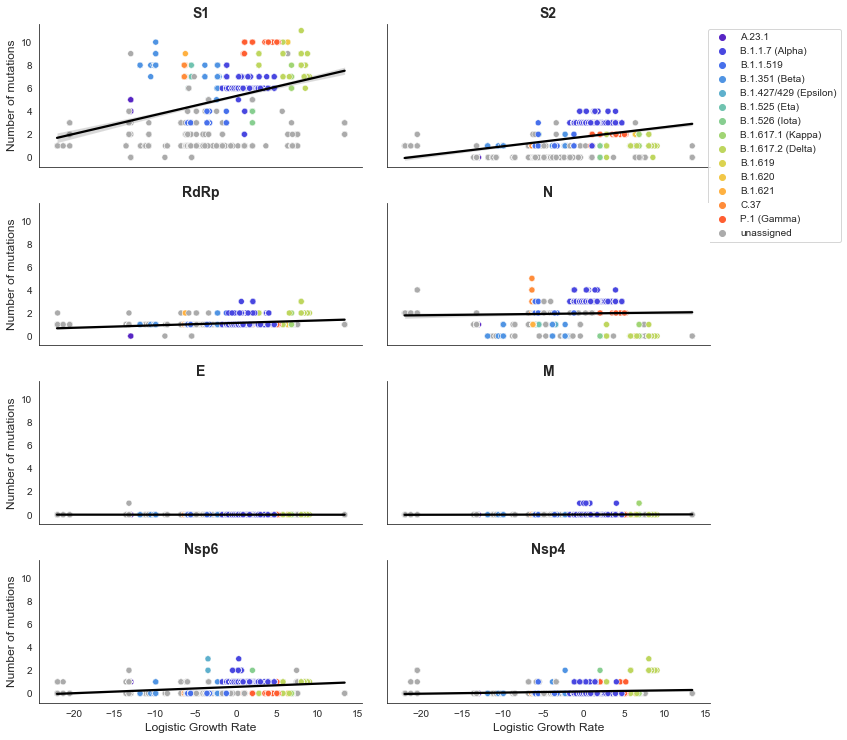

In [180]:
plot_muts_vs_logistic_growth_all_genes(filename = 'plots/fig1_supp.png')

In [197]:
plot_accumulation_s1_mutations = []

for node in tree.find_clades(terminal=True):

    node_path = get_parent(tree, node)
    
    for parent in node_path:

        num_date = parent.node_attrs['num_date']['value']


        s1_mutations = parent.node_attrs["s1_muts"]
        s2_mutations = parent.node_attrs["s2_muts"]
        rdrp_mutations = parent.node_attrs["rdrp_muts"]
        s1_syn_mutations = parent.node_attrs['s1_syn']



        plot_accumulation_s1_mutations.append({'date': num_date, 
                                               'num_s1_mutations': s1_mutations, 
                                               'num_s2_mutations': s2_mutations,
                                               'num_rdrp_mutations': rdrp_mutations,
                                               'num_s1_syn_mutations': s1_syn_mutations,
                                               'isolate': node.name})


df = pd.DataFrame(plot_accumulation_s1_mutations)

In [338]:
def make_fig_2a(filename=None):    
    
    lineage_colors = {"A.23.1": "#5725c4", "B.1.1.7 (Alpha)": "#4947e0", "B.1.1.519": "#4770eb",
            "B.1.351 (Beta)": "#5094e3", "B.1.427/429 (Epsilon)":"#5eb0cd", 
            "B.1.525 (Eta)":"#70c3b0", "B.1.526 (Iota)":"#87ce90", 
            "B.1.617.1 (Kappa)":"#a1d574", "B.1.617.2 (Delta)":"#bed65e", "B.1.619":"#dbd350", 
            "B.1.620":"#f2c747", "B.1.621":"#ffb141",
            "C.37":"#ff8c3a", "P.1 (Gamma)":"#ff5e31", 'unassigned':"#ABABAB"}



    # to make this more legible, only look at a couple paths
    # pick node from each emerging clade

    nodes_to_plot = {
        'Thailand/DMSc-00230/2021':"B.1.1.7 (Alpha)", 
        'Bangladesh/ideSHi-TR-2434/2021':"B.1.351 (Beta)", 
        'Australia/SA0728/2021': "B.1.617.2 (Delta)",
#         'Australia/NSW-R0281/2021': "B.1.617.2 (Delta)",
        'USA/MA-CDC-ASC210106413/2021': "P.1 (Gamma)"
#         'Suriname/SR-259/2021': "P.1 (Gamma)"
    }

    cmap = {k:lineage_colors[v] for k,v in nodes_to_plot.items()}

    df_subset = df[df['isolate'].isin(nodes_to_plot.keys())]


    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,4), sharey=True, sharex=True)
    plt.tight_layout()


    sns.lineplot(data=df_subset, x='date', y='num_s1_mutations', 
                 hue='isolate', palette=cmap, ax=ax1, legend=False)
    sns.scatterplot(data=df_subset, x='date', y='num_s1_mutations', 
                    hue='isolate', palette=cmap, ax=ax1, legend=False)
    
    sns.lineplot(data=df_subset, x='date', y='num_s1_syn_mutations', 
                 hue='isolate', palette=cmap, ax=ax2, legend=False)
    sns.scatterplot(data=df_subset, x='date', y='num_s1_syn_mutations', 
                    hue='isolate', palette=cmap, ax=ax2, legend=False)

    sns.lineplot(data=df_subset, x='date', y='num_rdrp_mutations', 
                 hue='isolate', palette=cmap, ax=ax3, legend=False)
    sns.scatterplot(data=df_subset, x='date', y='num_rdrp_mutations', 
                    hue='isolate', palette=cmap, ax=ax3, legend=True)

    ax1.set_title('S1 nonsynonymous', fontsize = 18)
    ax1.set_ylabel('Number of mutations', fontsize = 16)
    ax1.set_xlabel('date', fontsize = 16)

    ax2.set_title('S1 synonymous', fontsize = 18)
    ax2.set_xlabel('date', fontsize = 16)

    ax3.set_title('RdRp nonsynonymous', fontsize = 18)
    ax3.set_xlabel('date', fontsize = 16)
    
    sns.despine(left=False, bottom=False)

    for ax in [ax1, ax2, ax3]:
        ax.tick_params(axis='y', which='major', labelsize=14)
        ax.tick_params(axis='x', which='major', labelsize=12)



    handles, labels = ax3.get_legend_handles_labels()
    lgd = ax3.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.7, 0.9), fontsize=12)

    plt.figtext(-0.02, 0.99, 'A', fontsize=24, fontweight='bold')
    
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')


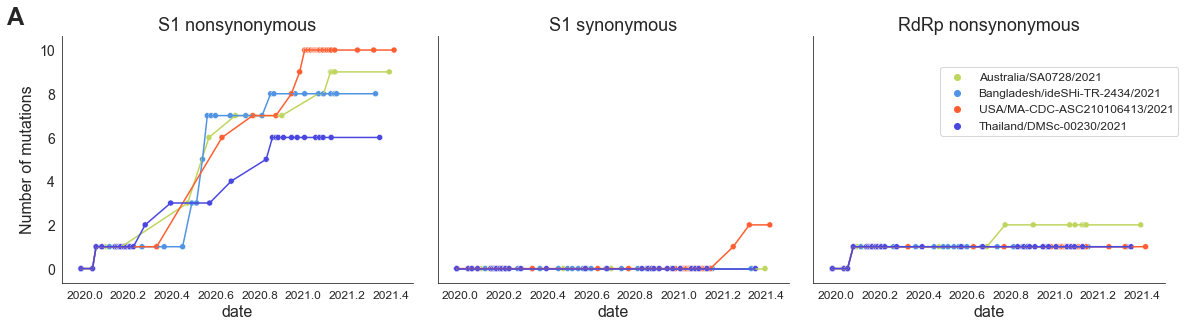

In [320]:
make_fig_2a('plots/fig2a_test.png')

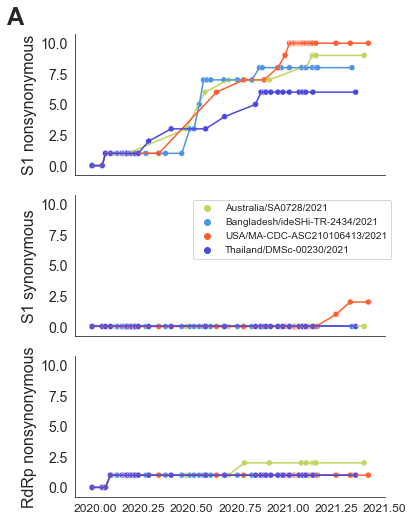

In [299]:
make_fig_2a(filename = 'plots/fig2a_mut_accumulation_timeline.png')